In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [3.0,2.0]

The goal of this notebook is to provide a synthetic picture of the origin of the CIB model in Choi et al. 

Let us first define several important quantities. 

In [38]:
choi_params_dict = {
# Amplitude of clustered CIB
'a_c':    3.15, # see table 7 of choi et al, the uncertainty is 0.72
# # Amplitude of Poisson CIB
'a_d':   6.58, # see table 7 of choi et al, the uncertainty is 0.37
'Tdust_CIB' : 9.7, # same as f90 act code
'nu0_CIB_ghz' : 150., # pivot frequency for CIB in choi et al, same as f90 act code 
'beta_CIB': 2.87, # see table 7 of choi et al, 2.87+0.34-0.54
    
    
# We note that some other values may be explored. As below.
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
    
# The power law indsex in multipole space for clustered CIB
# cib ~  l(l+1) l^n
# note that we do not use that explicitely in choi at el 
# 'cibc_n' : -1.2, # this is related to the 0.8 exponent, since 

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
# pivot multipole, so the template is such that Dl = 1 and this pivot scale 
'high_ell0' : 3000
}

In [39]:
TCMB = 2.725 #Kelvin # 2.725 value in choi et al
TCMB_uK = 2.725e6 #micro-Kelvin # 2.725 value in choi et al 


hplanck=6.626068e-34 #MKS
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
m_elec = 510.999 #keV

# function needed for Planck bandpass integration/conversion following approach in Sec. 3.2 of https://arxiv.org/pdf/1303.5070.pdf
# blackbody derivative
# units are 1e-26 Jy/sr/uK_CMB
def dBnudT(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz)
    X = hplanck*nu/(kboltz*TCMB)
    return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK

# conversion from specific intensity to Delta T units (i.e., 1/dBdT|T_CMB)
#   i.e., from W/m^2/Hz/sr (1e-26 Jy/sr) --> uK_CMB
#   i.e., you would multiply a map in 1e-26 Jy/sr by this factor to get an output map in uK_CMB
def ItoDeltaT(nu_ghz):
    return 1./dBnudT(nu_ghz)

In [11]:

def get_mu(p,nu_ghz):
        nu = 1.e9*np.asarray(nu_ghz).astype(float)
        X_CIB = hplanck*nu/(kboltz*(p['Tdust_CIB']))
        nu0_CIB = p['nu0_CIB_ghz']*1.e9
        dust_beta_param_name = 'beta_CIB'
        X0_CIB = hplanck*nu0_CIB/(kboltz*(p['Tdust_CIB']))
        resp = (nu/nu0_CIB)**(3.0+(p[dust_beta_param_name])) * ((np.exp(X0_CIB) - 1.0) / (np.exp(X_CIB) - 1.0)) * (ItoDeltaT(np.asarray(nu_ghz).astype(float))/ItoDeltaT(p['nu0_CIB_ghz']))
        resp[np.where(nu_ghz == None)] = 0. #this case is appropriate for HI or other maps that contain no CMB-relevant signals (and also no CIB); they're assumed to be denoted by None in nu_ghz
        return resp
    
from scipy.interpolate import interp1d
def get_template(ells,template_file,ell_pivot=None):
    ls,pow = np.loadtxt(template_file,unpack=True)
    powfunc = interp1d(ls,pow)
    if ell_pivot is not None:
        pow_pivot = powfunc(ell_pivot)
    else:
        pow_pivot = 1.
    return powfunc(ells)/pow_pivot

In [40]:
planck_2013 ={
'217x217':{
'cl' : np.asarray([
1.78e3, # < this is an upper bound
8.47e2, # < this is an upper bound
4.17e2, 
2.62e2, 
1.75e2, 
1.17e2, 
8.82e1, 
6.42e1, 
3.34e1, 
4.74e1
]),
'ecl' : np.asarray([
0.,
0., 
0.47e2, 
0.20e2, 
0.13e2, 
0.10e2, 
0.89e1, 
1.61e1, 
2.15e1, 
0.65e1
]),
'ell': np.asarray([
53,
114,
187,
320, 
502, 
684, 
890,
1158, 
1505,
1956
])
},

    '143x143':{'cl':np.asarray([1.55e2, 6.41e1, 3.64e1, 3.23e1, 2.81e1, 2.27e1, 1.84e1, 1.58e1, 1.25e1]),
               'ecl':np.asarray([0.,0., 0.73e1, 0.35e1, 0.30e1, 0.29e1, 0.35e1, 0.91e1, 1.28e1]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505])},
    '353x353':{'cl':np.asarray([3.68e4, 1.66e4, 7.88e3, 4.35e3, 2.60e3, 1.74e3, 1.29e3, 9.35e2, 7.75e2, 6.08e2]),
               'ecl':np.asarray([0.,0., 0.53e3, 0.18e3, 0.10e3, 0.07e3, 0.05e3, 0.33e2, 0.22e2, 0.16e2]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '545x545':{'cl':np.asarray([3.74e5, 1.45e5, 6.63e4, 3.34e4, 1.91e4, 1.25e4, 9.17e3, 6.83e3, 5.34e3, 4.24e3, 3.42e3]),
               'ecl':np.asarray([0.,0., 0.51e4, 0.12e4, 0.04e4, 0.03e4, 0.17e3, 0.10e3, 0.06e3, 0.04e3, 0.04e3]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])},
    '857x857':{'cl':np.asarray([2.76e6, 7.99e5, 2.87e5, 1.34e5, 7.20e4, 4.38e4, 3.23e4, 2.40e4, 1.83e4, 1.46e4, 1.16e4]),
               'ecl':np.asarray([0.,0., 0.37e5, 0.08e5, 0.26e4, 0.18e4, 0.09e4, 0.05e4, 0.03e4, 0.02e4, 0.01e4]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])}
}

In [64]:
##################################################################################
##################################################################################
# Here i borrow codes from Emmanuel Schaan 
# see https://github.com/EmmanuelSchaan/LensQuEst/blob/master/pn_2d.py
class Planck13CIBData(object):
    """Measured CIB power spectra from Planck13 XXX
    """

    # here name has to be the frequency of the CIB map
    def __init__(self):

      # Shot noise on CIB power spectra
      # table 9 from Planck13 XXX on CIB
      # unit is Jy^2 / sr
      self.PlanckPCIBShot = {}
      self.PlanckPCIBShot['857'] = 5364.
      self.PlanckPCIBShot['857_545'] = 2701.
      self.PlanckPCIBShot['857_353'] = 953.
      self.PlanckPCIBShot['857_217'] = 181.
      self.PlanckPCIBShot['545'] = 1690.
      self.PlanckPCIBShot['545_353'] = 626.
      self.PlanckPCIBShot['545_217'] = 121.
      self.PlanckPCIBShot['353'] = 262.
      self.PlanckPCIBShot['353_217'] = 54.
      self.PlanckPCIBShot['217'] = 21.

      # Measured CIB power spectra
      # table D2 from Planck13 XXX on CIB
      # unit is Jy^2/sr
      self.PlanckPCIB = {}

      # ell values
      self.PlanckPCIB['ell'] = np.array([53., 114., 187., 320., 502., 684., 890., 1158., 1505., 1956., 2649.])

      # Auto and cross spectra of the CIB: these maps are CMB-free, Galactic dust-free, corrected for SZ contamination and CIB contamination from CMB template
      # The values of the spectra at the first two ell values are only upper limits
      self.PlanckPCIB['857'] = np.array([0., 0., 2.87e5, 1.34e5, 7.20e4, 4.38e4, 3.23e4, 2.40e4, 1.83e4, 1.46e4, 1.16e4])
      self.PlanckPCIB['857_545'] = np.array([0., 0., 1.30e5, 6.36e4, 3.53e4, 2.21e4, 1.63e4, 1.22e4, 9.31e3, 7.38e3, 5.91e3])
      self.PlanckPCIB['857_353'] = np.array([0., 0., 4.30e4, 2.20e4, 1.25e4, 7.99e3, 5.88e3, 4.25e3, 3.24e3, 2.54e3, 0.])
      self.PlanckPCIB['857_217'] = np.array([0., 0., 9.70e3, 5.26e3, 3.03e3, 1.88e3, 1.31e3, 9.18e2, 7.00e2, 5.38e2, 0.])
      self.PlanckPCIB['857_143'] = np.array([0., 0., 1.84e3, 1.06e3, 6.52e2, 3.86e2, 2.55e2, 1.76e2, 1.23e2, 1.03e2, 0.])
      #
      self.PlanckPCIB['545'] = np.array([0., 0., 6.63e4, 3.34e4, 1.91e4, 1.25e4, 9.17e3, 6.83e3, 5.34e3, 4.24e3, 3.42e3])
      self.PlanckPCIB['545_353'] = np.array([0., 0., 2.22e4, 1.19e4, 6.93e3, 4.61e3, 3.39e3, 2.50e3, 1.93e3, 1.52e3, 0.])
      self.PlanckPCIB['545_217'] = np.array([0., 0., 4.97e3, 2.79e3, 1.65e3, 1.06e3, 7.41e2, 5.38e2, 4.30e2, 3.30e2, 0.])
      self.PlanckPCIB['545_143'] = np.array([0., 0., 1.01e3, 5.98e2, 3.77e2, 2.29e2, 1.54e2, 1.03e2, 7.09e1, 5.89e1, 0.])
      #
      self.PlanckPCIB['353'] = np.array([0., 0., 7.88e3, 4.35e3, 2.60e3, 1.74e3, 1.29e3, 9.35e2, 7.45e2, 6.08e2, 0.])
      self.PlanckPCIB['353_217'] = np.array([0., 0., 1.75e3, 1.02e3, 6.21e2, 3.97e2, 2.87e2, 1.99e2, 1.59e2, 1.35e2, 0.])
      self.PlanckPCIB['353_143'] = np.array([0., 0., 3.61e2, 2.32e2, 1.48e2, 9.42e1, 6.33e1, 4.56e1, 2.77e1, 3.53e1, 0.])
      #
      self.PlanckPCIB['217'] = np.array([0., 0., 4.17e2, 2.62e2, 1.75e2, 1.17e2, 8.82e1, 6.42e1, 3.34e1, 4.74e1, 0.])
      self.PlanckPCIB['217_143'] = np.array([0., 0., 1.04e2, 7.49e1, 5.87e1, 3.93e1, 2.64e1, 2.21e1, 1.07e1, 1.45e1, 0.])
      #
      self.PlanckPCIB['143'] = np.array([0., 0., 3.64e1, 3.23e1, 2.81e1, 2.27e1, 1.84e1, 1.58e1, 1.25e1, 0., 0.])

      # Error bars on the power spectra:
      self.PlanckPCIB['857_error'] = np.array([2.76e6, 7.99e5, 0.37e5, 0.08e5, 0.26e4, 0.18e4, 0.09e4, 0.05e4, 0.03e4, 0.02e4, 0.01e4])
      self.PlanckPCIB['857_545_error'] = np.array([9.73e5, 3.23e5, 0.13e5, 0.30e4, 0.10e4, 0.07e4, 0.04e4, 0.02e4, 0.11e3, 0.07e3, 0.06e3])
      self.PlanckPCIB['857_353_error'] = np.array([2.91e5, 1.05e5, 0.41e4, 0.11e4, 0.06e4, 0.39e3, 0.27e3, 0.17e3, 0.10e3, 0.07e3, 0.])
      self.PlanckPCIB['857_217_error'] = np.array([6.43e4, 2.49e4, 1.22e3, 0.53e3, 0.32e3, 0.22e3, 0.16e3, 0.87e2, 0.23e2, 0.12e2, 0.])
      self.PlanckPCIB['857_143_error'] = np.array([1.81e4, 5.12e3, 0.45e3, 0.12e3, 0.59e2, 0.41e2, 0.30e2, 0.23e2, 0.16e2, 0.15e2, 0.])
      #
      self.PlanckPCIB['545_error'] = np.array([3.74e5, 1.45e5, 0.51e4, 0.12e4, 0.04e4, 0.03e4, 0.17e3, 0.10e3, 0.06e3, 0.04e3, 0.04e3])
      self.PlanckPCIB['545_353_error'] = np.array([1.15e5, 4.84e4, 0.16e4, 0.05e4, 0.23e3, 0.16e3, 0.11e3, 0.07e3, 0.04e3, 0.03e3, 0.])
      self.PlanckPCIB['545_217_error'] = np.array([2.58e4, 1.16e4, 0.48e3, 0.21e3, 0.12e3, 0.09e3, 0.63e2, 0.35e2, 0.12e2, 0.07e2, 0.])
      self.PlanckPCIB['545_143_error'] = np.array([7.04e3, 2.53e3, 0.19e3, 0.67e2, 0.39e2, 0.27e2, 0.19e2, 0.14e2, 1.80e1, 1.73e1, 0.])
      #
      self.PlanckPCIB['353_error'] = np.array([3.68e4, 1.66e4, 0.53e3, 0.18e3, 0.10e3, 0.07e3, 0.05e3, 0.33e2, 0.22e2, 0.16e2, 0.])
      self.PlanckPCIB['353_217_error'] = np.array([8.01e3, 3.82e3, 0.15e3, 0.06e3, 0.38e2, 0.27e2, 0.20e2, 0.14e2, 0.10e2, 0.05e2, 0.])
      self.PlanckPCIB['353_143_error'] = np.array([2.05e3, 8.26e2, 0.62e2, 0.24e2, 0.14e2, 1.06e1, 0.83e1, 0.91e1, 1.11e1, 0.69e1, 0.])
      #
      self.PlanckPCIB['217_error'] = np.array([1.78e3, 8.47e2, 0.47e2, 0.20e2, 0.13e2, 0.10e2, 0.89e1, 1.61e1, 2.15e1, 0.65e1, 0.])
      self.PlanckPCIB['217_143_error'] = np.array([4.74e2, 1.89e2, 0.19e2, 0.81e1, 0.58e1, 0.50e1, 0.52e1, 1.19e1, 1.65e1, 0.54e1, 0.])
      #
      self.PlanckPCIB['143_error'] = np.array([1.55e2, 6.41e1, 0.73e1, 0.35e1, 0.30e1, 0.29e1, 0.35e1, 0.91e1, 1.28e1, 0., 0.])



    ##################################################################################

    def plotPCIB(self, name='353'):
      L = self.PlanckPCIB['ell']
      P = self.PlanckPCIB[name]
      sP = self.PlanckPCIB[name+'_error']
      Pshot = self.PlanckPCIBShot[name]

      # P
      fig = plt.figure(figsize = (10,6))
      ax = plt.subplot(111)
      #
      ax.errorbar(L, P, yerr=sP, fmt='.', c='k', label=name)
      ax.plot(L, Pshot*np.ones_like(L), 'b--', label=r'quoted shot noise')
      #
      ax.set_xscale('log')
      ax.set_yscale('log')
      ax.legend(loc=1, numpoints=1)
      ax.set_xlabel(r'\ell')
      ax.set_ylabel(r'$C_\ell^\mathrm{CIB}$')
      plt.show()
        
    def plotcib_line(self, name = '353'):
      L = self.PlanckPCIB['ell']
      P = self.PlanckPCIB[name]
      sP = self.PlanckPCIB[name+'_error']
      Pshot = self.PlanckPCIBShot[name]
      ax.errorbar(L, P, yerr=sP, fmt='.', c='k', label='Planck '+name)
      ax.plot(L, Pshot*np.ones_like(L), 'b--', label=r'Planck quoted shot noise')



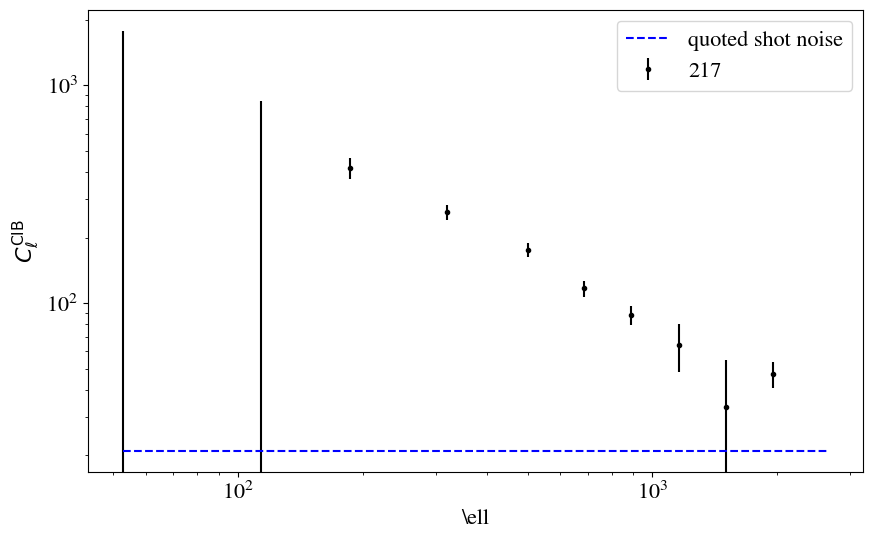

In [69]:
# for example we can plot the planck cib data like:
plcib = Planck13CIBData()
plcib.plotPCIB('217')

Plot at 217GHZ, comparison with Choi et al 

In [72]:
# factors for units
# the conversion factor 483.690 appears in table 1 of 
# Planck Collaboration: P. A. R. Ade, N. Aghanim, C. Armitage-Caplan, et al. 
# "Planck 2013 results. XXX. Cosmic infrared background measurements and implications for star formation." 
# Astronomy & Astrophysics, 571, A30 (2014). DOI: 10.1051/0004-6361/201322093
# it is the conversion factor from MJy*sr^-1 to Kcmb at 217GHz


convfac = 483.690

(10.0, 10000.0)

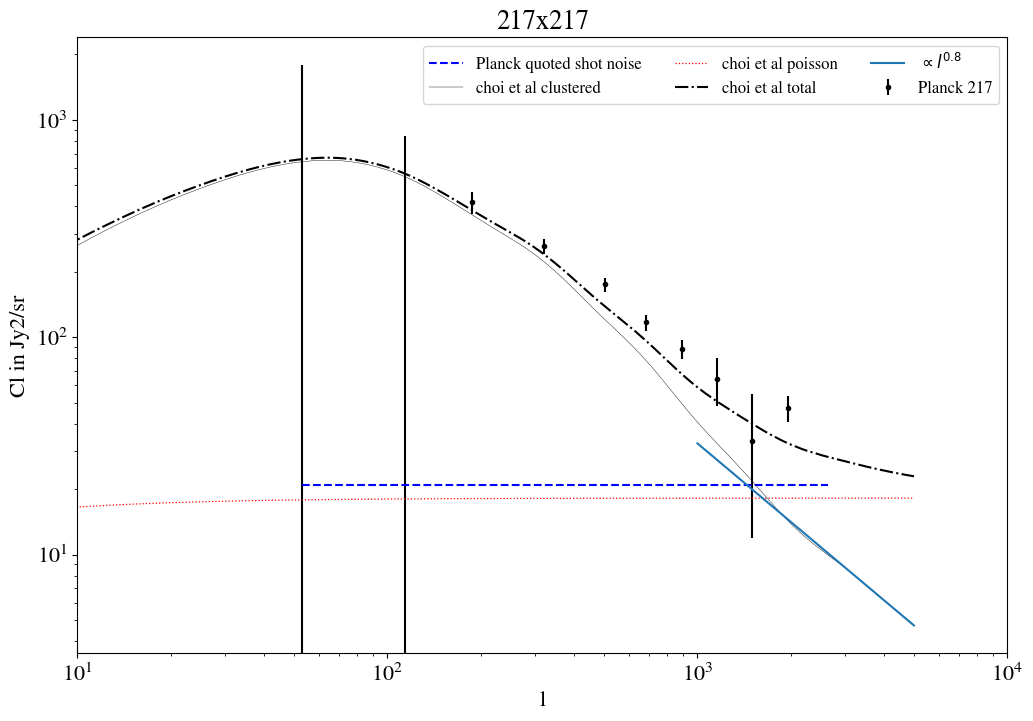

In [73]:
fig, (ax) = plt.subplots(1,1,figsize=(12,8))
freq = '217x217'
freq1 = float(freq.split('x')[0])



plcib = Planck13CIBData()
plcib.plotcib_line('217')



l = np.arange(2,5000)
l0 = choi_params_dict['high_ell0']
cib_temp = get_template(ells,choi_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(l,choi_params_dict['a_c']*cib_temp/(l*(l+1.)/2./np.pi)*(convfac)**2.*get_mu(choi_params_dict,[217])**2.,label='choi et al clustered',c='k',lw=0.3)


cibp = choi_params_dict['a_d']*(l/l0)**(2)*get_mu(choi_params_dict,[freq1])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(convfac)**2.,label='choi et al poisson',lw=0.9,c='r',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(convfac)**2.+choi_params_dict['a_c']*cib_temp/(l*(l+1.)/2./np.pi)*(convfac)**2.*get_mu(choi_params_dict,[freq1])**2.,
         label='choi et al total',c='k',ls='-.')

lpow = l[l>1000]
clpow = (l[l>1000]/l0)**0.8*choi_params_dict['a_c']/(lpow*(lpow+1.)/2./np.pi)*(convfac)**2.*get_mu(choi_params_dict,[217])**2.
plt.plot(lpow,clpow,label=r'$\propto l^{0.8}$')

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)

Adding Maniyar model (parameters not adjusted)

In [93]:
%%time
import classy_sz
from classy_sz import Class
# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi


Omegam0 = 0.3075
H0 = 67.74
Omegab = 0.0486
Omegac = 0.2589
Omegac + Omegab
omega_b = Omegab*(H0/100.)**2
omega_c = Omegac*(H0/100.)**2
hparam = H0/100.
maniyar_cosmo = {
'omega_b': omega_b,
'omega_cdm':  omega_c,
'h': H0/100.,
# 'tau_reio': 0.0561,
'ln10^{10}A_s': 3.048,
'n_s': 0.9665,
# 'sigma8':0.830,
'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.0
}


M = Class()
M.set({'output':'dndlnM,cib_cib_1h,cib_cib_2h'})
M.set(maniyar_cosmo)
M.set({

'mass function' : 'T08M200c',
'use_maniyar_cib_model':1,

'maniyar_cib_etamax' : 5.12572945e-01,

'maniyar_cib_zc' : 1.5,
'maniyar_cib_tau' : 8.25475287e-01,
'maniyar_cib_fsub' : 0.134*np.log(10.),
'Most_efficient_halo_mass_in_Msun' : 5.34372069e+12,
'Size_of_halo_masses_sourcing_CIB_emission' :  1.5583436676980493,
#for the Lsat tabulation:
'freq_min': 9e1,
'freq_max': 8.57e2,
'dlogfreq' : 0.1,

'concentration parameter':'fixed', # this sets it to 5

'n_z_L_sat' :100,
'n_m_L_sat' :100,
'n_nu_L_sat':100,

'use_nc_1_for_all_halos_cib_HOD': 1,

'sub_halo_mass_function' : 'TW10',#'JvdB14',
'M_min_subhalo_in_Msun' : 1e5, # 1e5 see https://github.com/abhimaniyar/halomodel_cib_tsz_cibxtsz/blob/master/Cell_cib.py
'use_redshift_dependent_M_min': 0,
'M_min' : 1e8*hparam,
'M_max' : 1e15*hparam,
'z_min' : 0.012,
'z_max' : 10.,
'ell_min': 10.,
'ell_max':5e4,
'dlogell':0.3,


'ndim_redshifts': 210,
'ndim_masses':150,

'has_cib_flux_cut': 0,
'hm_consistency':0,

'epsabs_L_sat': 1e-40,
'epsrel_L_sat': 1e-9,
    
'damping_1h_term':0,

# "P_k_max_1/Mpc": 50.,
# 'k_max_for_pk_class_sz':50.
})

M.set({
       'cib_frequency_list_num' : 6,
       'cib_frequency_list_in_GHz' : '100,143,217,353,545,857',
      })
M.compute()

CPU times: user 5min 46s, sys: 1.21 s, total: 5min 47s
Wall time: 42.7 s


In [99]:
lmaniyar, clmaniyar1h, clmaniyar2h = np.asarray(M.cl_cib_cib()['217x217']['ell']),np.asarray(M.cl_cib_cib()['217x217']['1h']),np.asarray(M.cl_cib_cib()['217x217']['2h'])




Planck = {'name': 'Planck',
          'do_cib': 1, 'do_tsz': 1, 'do_cibxtsz': 1,
          'freq_cib': [100., 143., 217., 353., 545., 857.],
          'cc': np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995, 0.960]),
          'cc_cibmean': np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995, 0.960]),
          'freq_cibmean': np.array([100., 143., 217., 353., 545., 857.]),
          'fc': np.ones(7),
          }

i = 2
j = 2
faccib = Planck['cc'][i]*Planck['cc'][j]


clmaniyar1h /= lmaniyar*(lmaniyar+1.)/2./np.pi/faccib
clmaniyar2h /= lmaniyar*(lmaniyar+1.)/2./np.pi/faccib

(10.0, 10000.0)

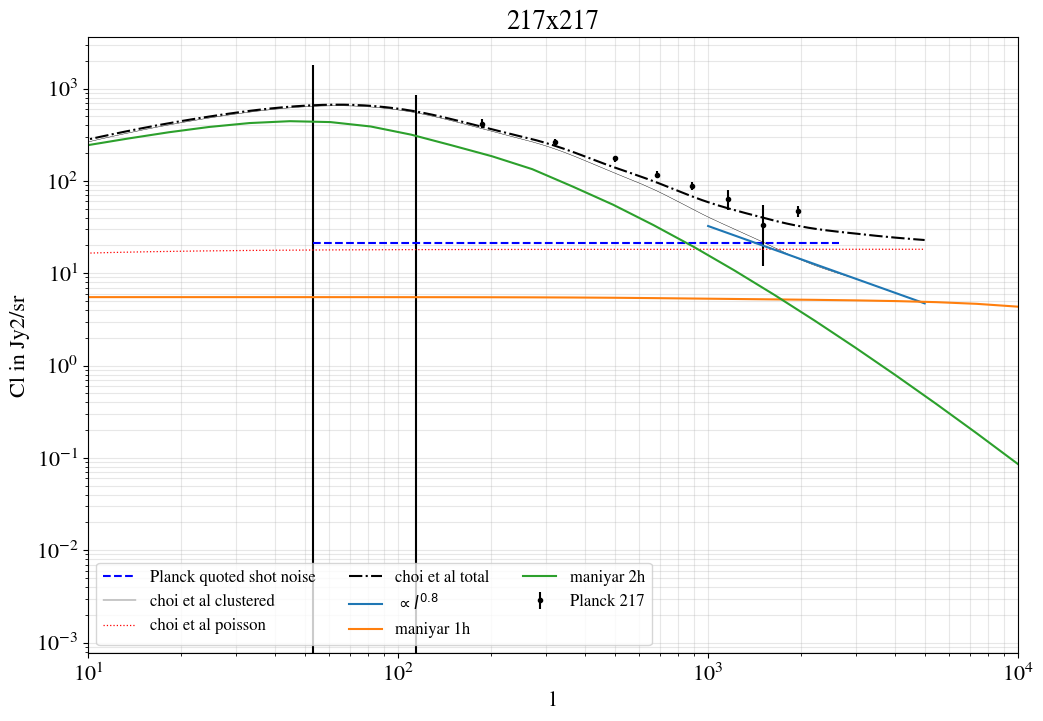

In [102]:
fig, (ax) = plt.subplots(1,1,figsize=(12,8))
freq = '217x217'
freq1 = float(freq.split('x')[0])



plcib = Planck13CIBData()
plcib.plotcib_line('217')



l = np.arange(2,5000)
l0 = choi_params_dict['high_ell0']
cib_temp = get_template(ells,choi_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(l,choi_params_dict['a_c']*cib_temp/(l*(l+1.)/2./np.pi)*(convfac)**2.*get_mu(choi_params_dict,[217])**2.,label='choi et al clustered',c='k',lw=0.3)


cibp = choi_params_dict['a_d']*(l/l0)**(2)*get_mu(choi_params_dict,[freq1])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(convfac)**2.,label='choi et al poisson',lw=0.9,c='r',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(convfac)**2.+choi_params_dict['a_c']*cib_temp/(l*(l+1.)/2./np.pi)*(convfac)**2.*get_mu(choi_params_dict,[freq1])**2.,
         label='choi et al total',c='k',ls='-.')

lpow = l[l>1000]
clpow = (l[l>1000]/l0)**0.8*choi_params_dict['a_c']/(lpow*(lpow+1.)/2./np.pi)*(convfac)**2.*get_mu(choi_params_dict,[217])**2.
plt.plot(lpow,clpow,label=r'$\propto l^{0.8}$')

plt.plot(lmaniyar,clmaniyar1h,label=r'maniyar 1h')
plt.plot(lmaniyar,clmaniyar2h,label=r'maniyar 2h')


plt.grid(which = 'both',alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)